In [31]:
import numpy as np
from scipy.linalg import eigh

import matplotlib.pyplot as plt

import functions as fu

## RSRG

### $\lambda = 0$

I study the case when $\lambda = 0$, computing the ground state energy and looking if they follow the expected behaviour of $E_g = -(N-1)$. A discrepacy between the theoretical and computed value can be thought as a measure of error.

In [87]:
# Parameters
N = 2
l = 0
threshold = 1e-3
max_iter = 15
d_eff = 2**N


normgs_eigval_dict, eigvec, deltas_dim, actual_dim = fu.real_space_rg(N, l, threshold, d_eff, max_iter)

gs_eigval = {N: N * en for N, en in normgs_eigval_dict.items()}

theoretical_eigval = {N: -(N-1) for N in normgs_eigval_dict.keys()}

error_eigval = {N: np.abs((gs_eigval[N] - theoretical_eigval[N])/theoretical_eigval[N]) for N in normgs_eigval_dict.keys()}


Convergence achieved at iteration 9: ε = -1.0075928028518546 

Converged reached for a system with N = 1024 sites, i.e. H.shape = (179769313486231590772930519078902473361797697894230657273430081157732675805500963132708477322407536021120113879871393357658789768814416622492847430639474124377767893424865485276302219601246094119453082952085005768838150682342462881473913110540827237163350510684586298239947245938479716304835356329624224137216x179769313486231590772930519078902473361797697894230657273430081157732675805500963132708477322407536021120113879871393357658789768814416622492847430639474124377767893424865485276302219601246094119453082952085005768838150682342462881473913110540827237163350510684586298239947245938479716304835356329624224137216), with precision: delta = 0.0006803556601158167


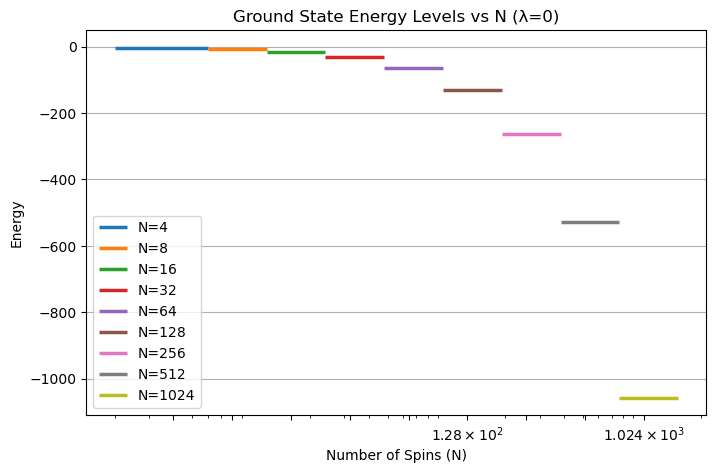

In [ ]:
plt.figure(figsize=(8, 5))

fu.plot_dict_N_GSen(gs_eigval, "hlines")

plt.xscale('log')
plt.xticks(list(gs_eigval.keys()))   # Set x-axis ticks to be exactly the N values
# plt.yticks(list(eigenvalues.values()))
plt.xlabel('Number of Spins (N)')
plt.ylabel('Energy')
plt.title(f'Ground State Energy Levels vs N (λ=0)')
plt.legend(loc='lower left')
plt.grid(axis='y')
plt.show()

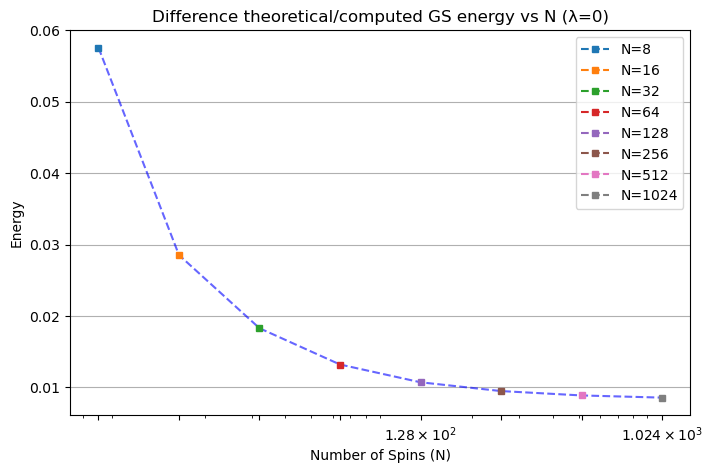

In [102]:
plt.figure(figsize=(8, 5))
plt.plot(list(error_eigval.keys())[1:],list(error_eigval.values())[1:], "--", color = "blue", alpha = 0.6)

fu.plot_dict_N_GSen(error_eigval, "plot")

plt.xscale('log')
plt.xticks(list(error_eigval.keys())[1:])   # Set x-axis ticks to be exactly the N values
# plt.yticks(list(eigenvalues.values()))
plt.xlabel('Number of Spins (N)')
plt.ylabel('Energy')
plt.title(f'Difference theoretical/computed GS energy vs N (λ=0)')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

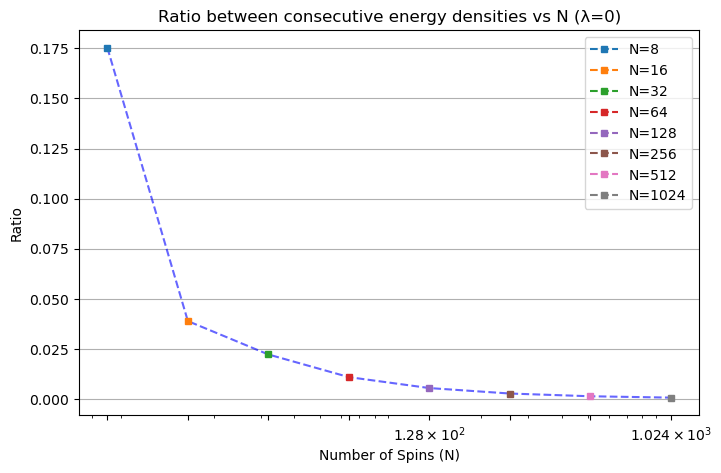

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(deltas_dim.keys())[1:],list(deltas_dim.values())[1:], "--", color = "blue", alpha = 0.6)

fu.plot_dict_N_GSen(deltas_dim, "plot")

plt.xscale('log')
plt.xticks(list(deltas_dim.keys())[1:])   # Set x-axis ticks to be exactly the N values
# plt.yticks(list(eigenvalues.values()))
plt.xlabel('Number of Spins (N)')
plt.ylabel('Ratio')
plt.title(f'Ratio between consecutive energy densities vs N (λ=0)')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

In these graphs we have compared the computed values of the ground state energies provided by the algorithm with the theoretical expectation value with lambda = 0. The error decreases as the number of spins increases, and it's below 1%

### $\lambda = \infty$

We can perform the same reasoning comparing the results provided by the RSRG with the theoretical ground state energy in this regime, namely $E_g = - \lambda \cdot N$.

## Comparison: RSRG - meanfield

Now I want to make a comparison between the rsrg and exact mean-field approaches. In order to do so, I will divide the analysis splitting 3 different situations: the case where $\lambda = 0$, $\lambda \simeq 1$ and $\lambda >> 1$. <br>

For each of these regimes i will test the situation in which I fix the maximum iterations (thus fixing the final number of sites)

In [63]:
import functions as fu
import numpy as np
from scipy.linalg import eigh

import matplotlib.pyplot as plt

import functions as fu
import meanfield as mf

# Parameters
N = 2
l = 0
threshold = 1e-3
max_iter = 2
d_eff = 2**N


gs_eigval_dict, eigvec, deltas_dim, actual_dim = fu.real_space_rg(N, l, threshold, d_eff, max_iter)

print(gs_eigval_dict)

exact_gs_energy, exact_gs = mf.diagonalize_ising(actual_dim, [l], k=1)

print(exact_gs_energy)

Convergence achieved at iteration 2: ε = -0.8875855034435671 

Converged reached for a system with N = 8 sites, i.e. H.shape = (256x256), with precision: delta = 0.13758550344356746
{4: -0.7499999999999997, 8: -0.8875855034435671}
Diagonalizing Ising Hamiltonian with N=4 ...
N =  4
Diagonalizing Ising Hamiltonian with N=8 ...
N =  8
{(4, 0): array([-0.75]), (8, 0): array([-0.875])}
